# Hyperparameter analysis in BTW model

The purpose of this notebook is to find out the effect of hyperparameter $a$ on the quality of predictions. Obviously, the larger hyperparameter $a$ means the larger the memory in AR(1) process. 

Let's calculate time when the forecast will contribute less than 1 to the decision variable:

$$ a^n \cdot s < 1$$

Under the assumption $a(L) = e^{-\frac{1}{T(L)}}$:

$$ e^{-\frac{n}{T(L)}} < 1 $$

Consequently:

$$ n > \ln s \cdot T(L) $$

In BTW model $s < L^3$, so in the worst case:

$$ n > 3 \ln L \cdot T(L) $$

However, this is a very strange result. In [Hallerberg et al.](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.80.026124), $T(L)$ doubled when the $L$ doubled. This means that the memory of the AR(1) model also doubled.

In [1]:
%load_ext autoreload
%autoreload 2

import os
os.chdir("../")

import sys
sys.path.insert(1, 'src/')

In [365]:
import abel_heap
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams['font.size'] = 36
plt.rcParams['axes.labelpad'] = 20
plt.rcParams['axes.titlepad'] = 30
plt.rcParams['xtick.minor.pad'] = 15
plt.rcParams['xtick.major.pad'] = 15
plt.rcParams['ytick.minor.pad'] = 15
plt.rcParams['ytick.major.pad'] = 15

## Previous scaling

$$ \eta = p \cdot s_{\max}, $$

where $s_{\max} = \frac{L(L+1)(L+2)}{6}$. And predict probability of events:

$$ s_i > \eta $$

In [366]:
get_eta_determ = lambda L, percent: int(L * (L+1) * (L+2) // 6 * percent)
get_a = lambda T: np.exp(-1. / T)

PERCENTS_ETA = [0.10, 0.15, 0.2, 0.25, 0.30]
LS = [64, 128, 256, 512]
TS = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1800, 1800*2, 1800*3, 1800*4, 1800*5, 1800*6]

args = []
for L in LS:
    for T in TS:
        A = get_a(T)
        for percent in PERCENTS_ETA:
            model = "determ"
            ETA = get_eta_determ(L, percent)
            args.append((L, ETA, A, model))

abel_heap.calculate_conditional_probability_parallel(args, K_BINS=200, use_cache=True, njobs=7)
auc_curve_determ = abel_heap.calculate_roc_curve_parallel(args, K_BINS=200, use_cache=True, njobs=7)

# calculate some useful columns

auc_curve_determ["eps"] = auc_curve_determ["results"].apply(lambda x: np.min(x[0] + (1 - x[1]))) # fpr + (1 - tpr)

A2T = {}
for T in TS:
    A2T[get_a(T)] = T
auc_curve_determ["T"]  = auc_curve_determ["A"].apply(lambda x: A2T[x])

EtaL2percent = {}
for L in LS:
    for percent in PERCENTS_ETA:
        EtaL2percent[(get_eta_determ(L, percent), L)] = percent

percents = []
for _, row in auc_curve_determ.iterrows():
    percents.append(str(int(EtaL2percent[(row["ETA"], row["L"])] * 100)) + "% $s_{max}$")
auc_curve_determ["$\eta$"] = percents

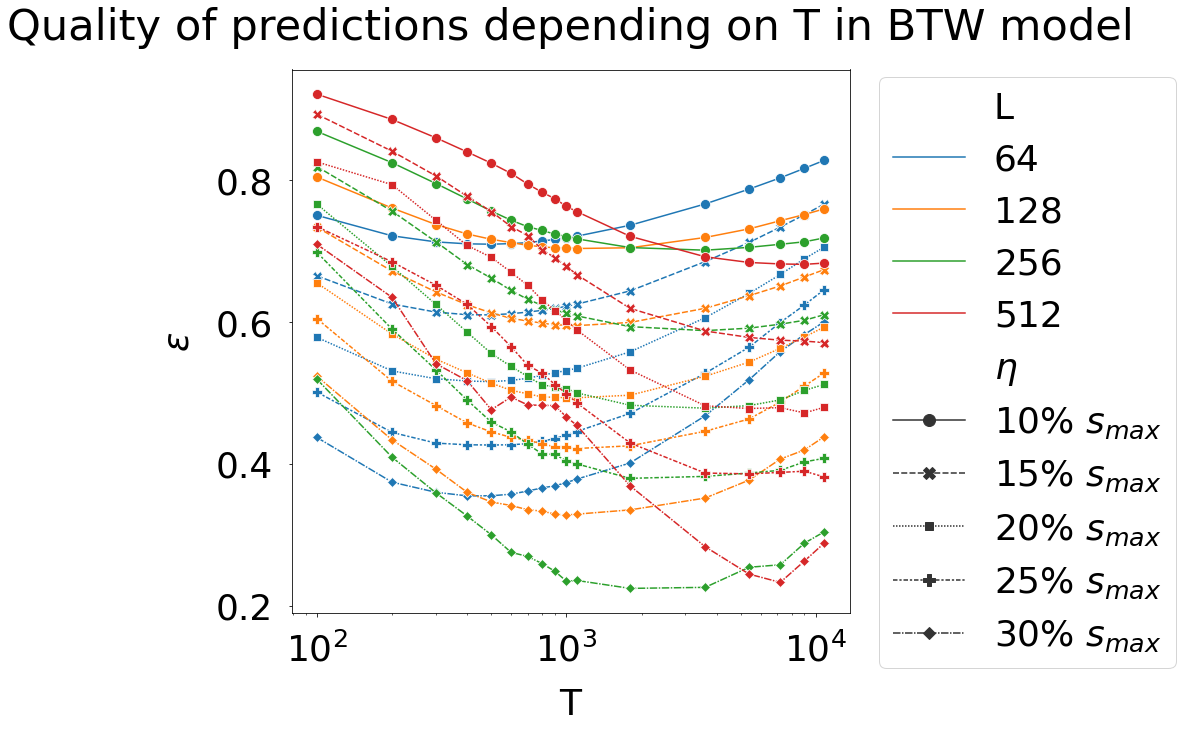

In [367]:
sns.lineplot(data=auc_curve_determ, x="T", y="eps", hue="L", style="$\eta$", markers=True, palette="tab10", markersize=10)
plt.title("Quality of predictions depending on T in BTW model")
plt.xlabel("T")
plt.ylabel("$\epsilon$")
plt.xscale("log")
plt.legend(bbox_to_anchor=(1.02,1.02), loc="upper left", markerscale=2)
plt.show()

### Short analysys

We see that doubling $T(L)$ is not an ideal strategy, and there are also problems with scaling, which deteriorates on large $L$. In part, this can be explained by the small predicted development of events.

## New scaling

Let's try to find optimal $\gamma$ for the following scaling:

$$ \eta = p \cdot L^{\gamma} $$

In [368]:
def plot_global_auc_curves(auc_curve, gamma, ax=None, legend=True):
    sns.lineplot(data=auc_curve, x="T", y="eps", hue="L", style="p", markers=True, palette="tab10", markersize=10, ax=ax)
    str_gamma = "{" + f"{gamma:.3}" + "}"
    if ax is None:
        #plt.title("Quality of predictions, $\gamma=$" + str(gamma))
        plt.xlabel("T")
        plt.ylabel("$\epsilon$")
        plt.xscale("log")
        if legend:
            plt.legend(bbox_to_anchor=(1.02,1.02), loc="upper left", markerscale=2)
    else:
        #ax.set_title("Quality of predictions, $\gamma=$" + str(gamma))
        ax.set_xlabel("T")
        ax.set_ylabel("$\epsilon$")
        ax.set_xscale("log")
        if legend:
            ax.legend(bbox_to_anchor=(1.02,1.02), loc="upper left", markerscale=2)

In [369]:
def calculate_roc_curve_gamma(gamma, PERCENTS_ETA, LS, TS, model, njobs=-1):
    # build args
    get_eta = lambda L, percent: int(L**gamma * percent)
    get_a = lambda T: np.exp(-1. / T)
    
    args = []
    add_t = []
    add_p = []
    add_gamma = []

    for L in LS:
        for T in TS:
            A = get_a(T)
            for percent in PERCENTS_ETA:
                ETA = get_eta(L, percent)
                
                add_t.append(T)
                add_p.append(percent)
                add_gamma.append(gamma)
                args.append((L, ETA, A, model))
    
    # run subprograms
    abel_heap.calculate_conditional_probability_parallel(args, K_BINS=200, use_cache=True, njobs=njobs)
    auc_curve = abel_heap.calculate_roc_curve_parallel(args, K_BINS=200, use_cache=True, njobs=njobs)

    # calculate some useful columns
    auc_curve["eps"] = auc_curve["results"].apply(lambda x: np.min(x[0] + (1 - x[1]))) # fpr + (1 - tpr)
    auc_curve["fpr"] = auc_curve["results"].apply(lambda x: list(x[0]))
    auc_curve["tpr"] = auc_curve["results"].apply(lambda x: list(x[1]))
    auc_curve["T"] = add_t
    auc_curve["p"] = add_p
    auc_curve["gamma"] = add_gamma
    
    return auc_curve

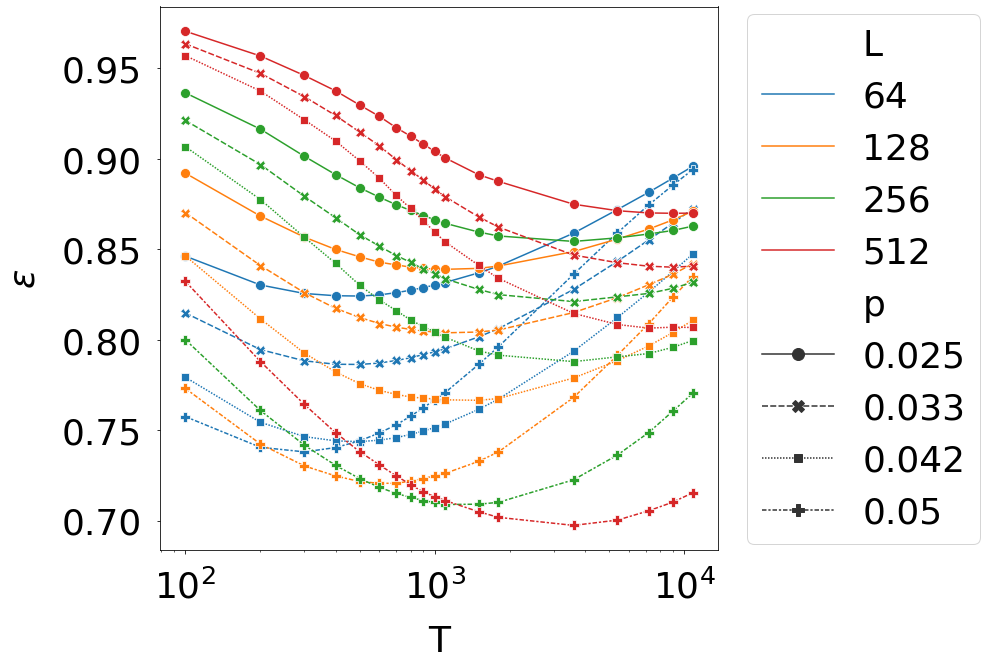

In [370]:
gamma = 2.75

# PERCENTS_ETA = [0.15 / 6 , 0.2 / 6, 0.25 / 6, 0.30 / 6]
PERCENTS_ETA = [0.025, 0.033, 0.042, 0.05] # approx of above line
LS = [64, 128, 256, 512]
TS = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1500, 1800, 1800*2, 1800*3, 1800*4, 1800*5, 1800*6]

auc_curve = calculate_roc_curve_gamma(gamma, PERCENTS_ETA, LS, TS, "determ", njobs=7)
plot_global_auc_curves(auc_curve, gamma)

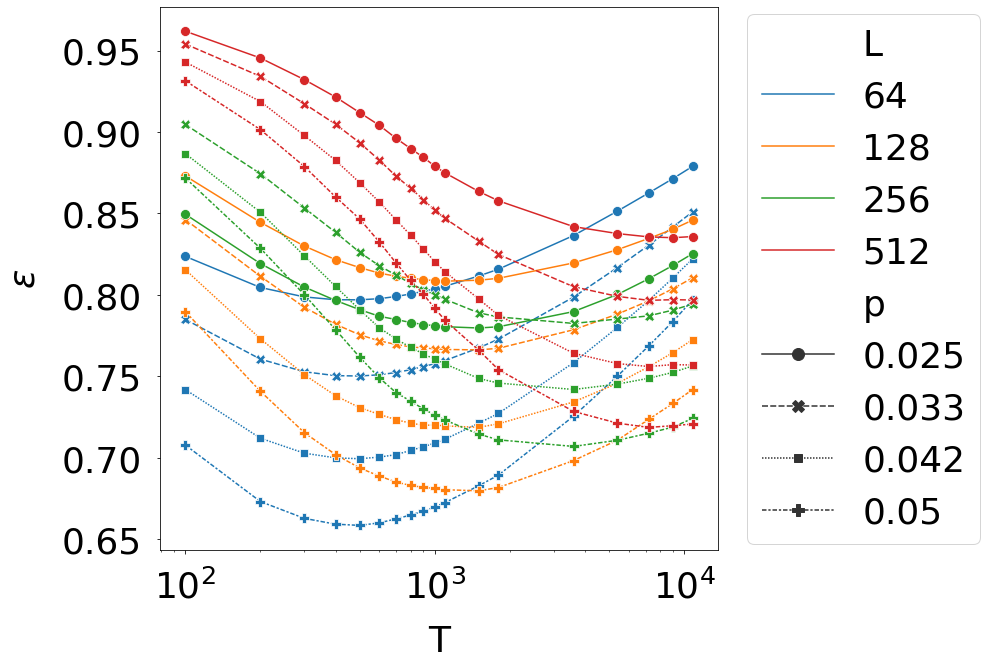

In [371]:
gamma = 2.8

auc_curve = calculate_roc_curve_gamma(gamma, PERCENTS_ETA, LS, TS, "determ", njobs=7)
plot_global_auc_curves(auc_curve, gamma)

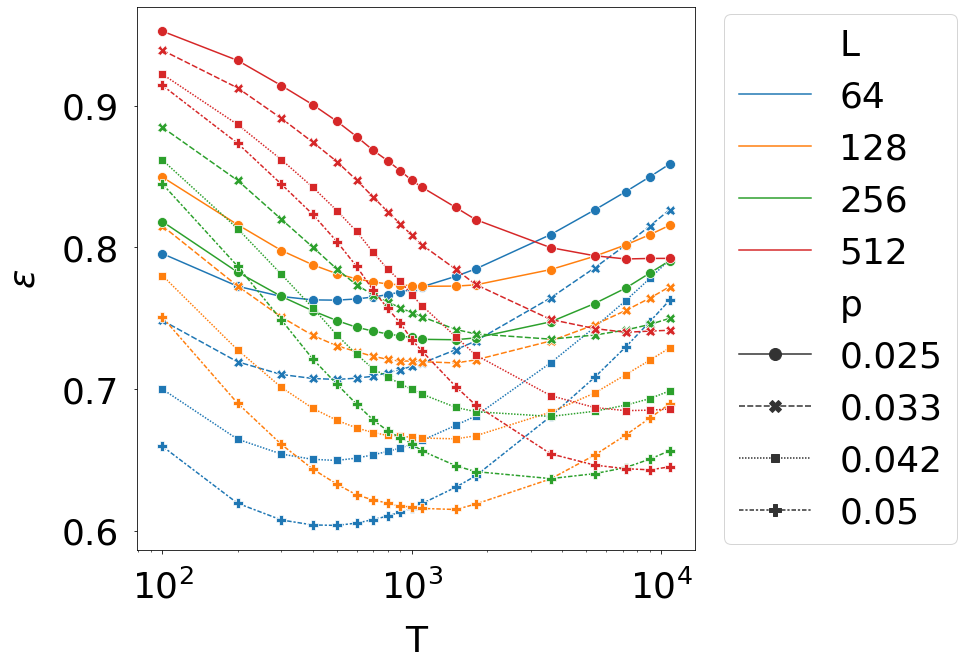

In [372]:
gamma = 2.85

auc_curve = calculate_roc_curve_gamma(gamma, PERCENTS_ETA, LS, TS, "determ", njobs=7)
plot_global_auc_curves(auc_curve, gamma)

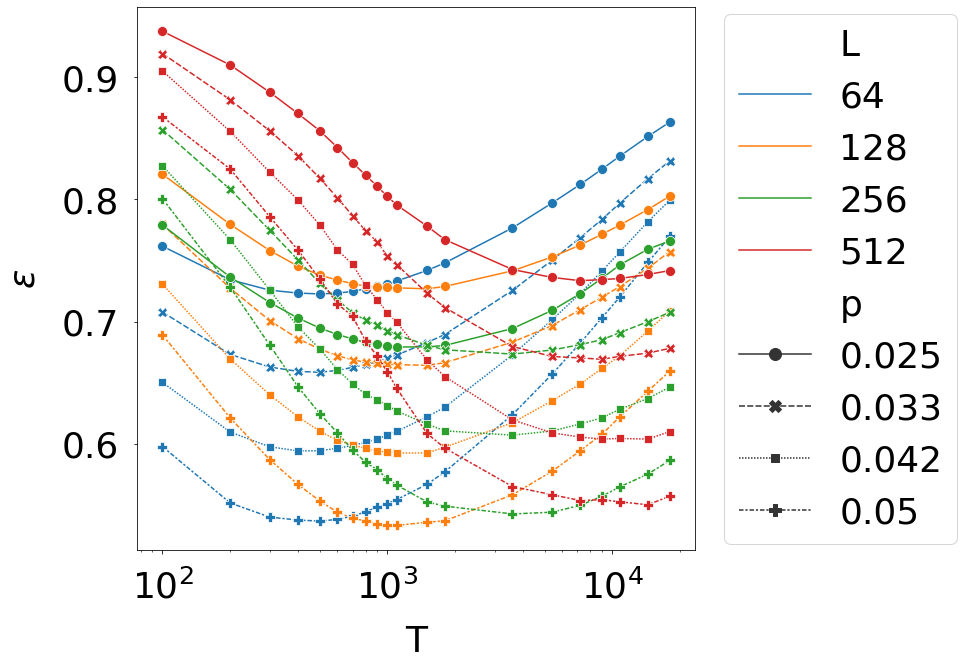

In [373]:
gamma = 2.9

TS = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1500, 1800, 1800*2, 1800*3, 1800*4, 1800*5, 1800*6, 1800*8, 1800*10]

auc_curve = calculate_roc_curve_gamma(gamma, PERCENTS_ETA, LS, TS, "determ", njobs=7)
plot_global_auc_curves(auc_curve, gamma)

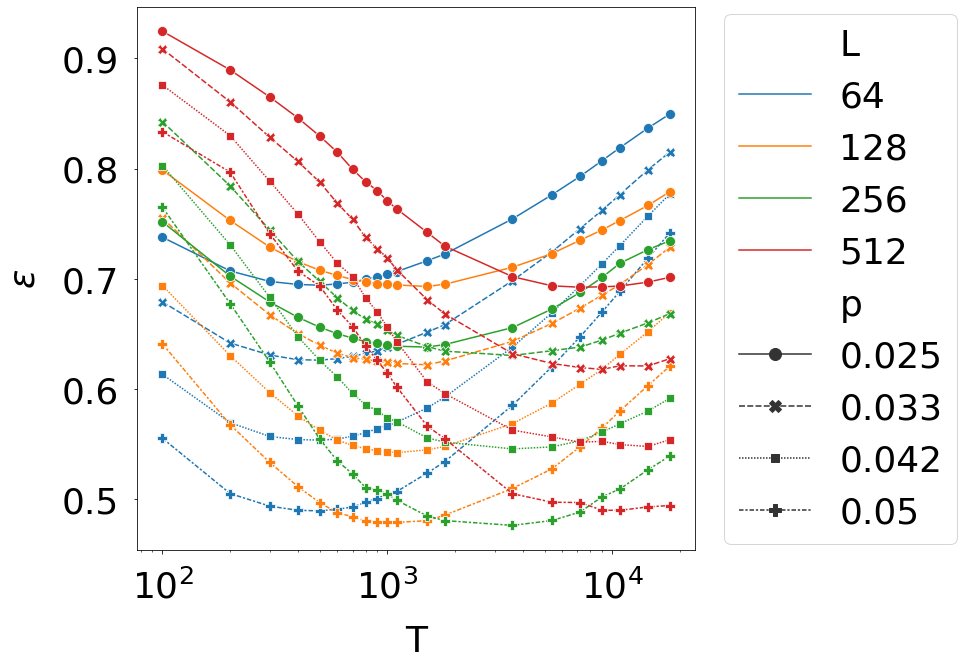

In [374]:
gamma = 2.93

auc_curve = calculate_roc_curve_gamma(gamma, PERCENTS_ETA, LS, TS, "determ", njobs=7)
plot_global_auc_curves(auc_curve, gamma)

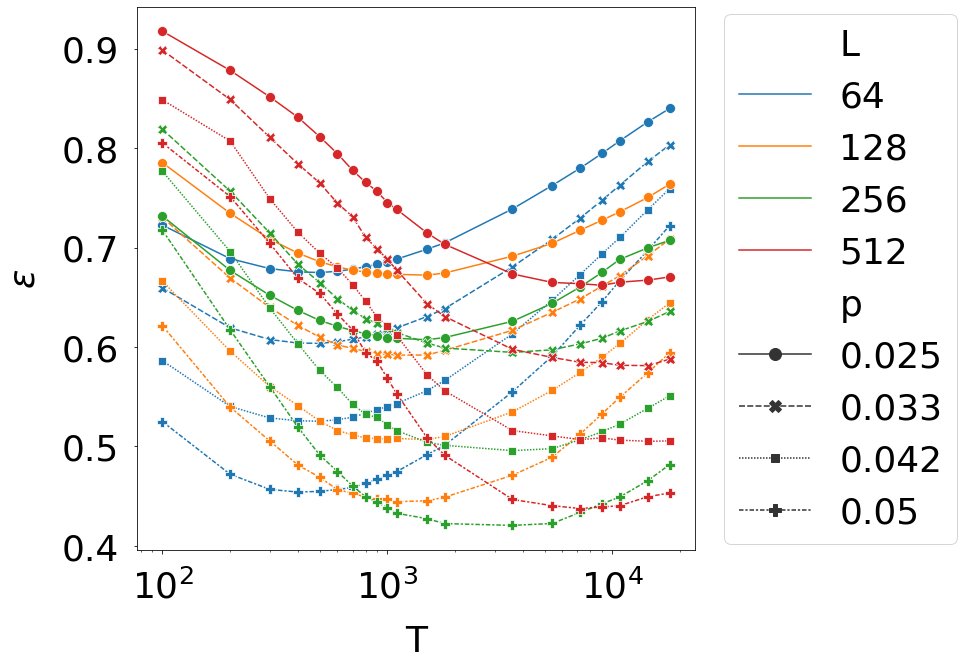

In [375]:
gamma = 2.95

auc_curve = calculate_roc_curve_gamma(gamma, PERCENTS_ETA, LS, TS, "determ", njobs=7)
plot_global_auc_curves(auc_curve, gamma)

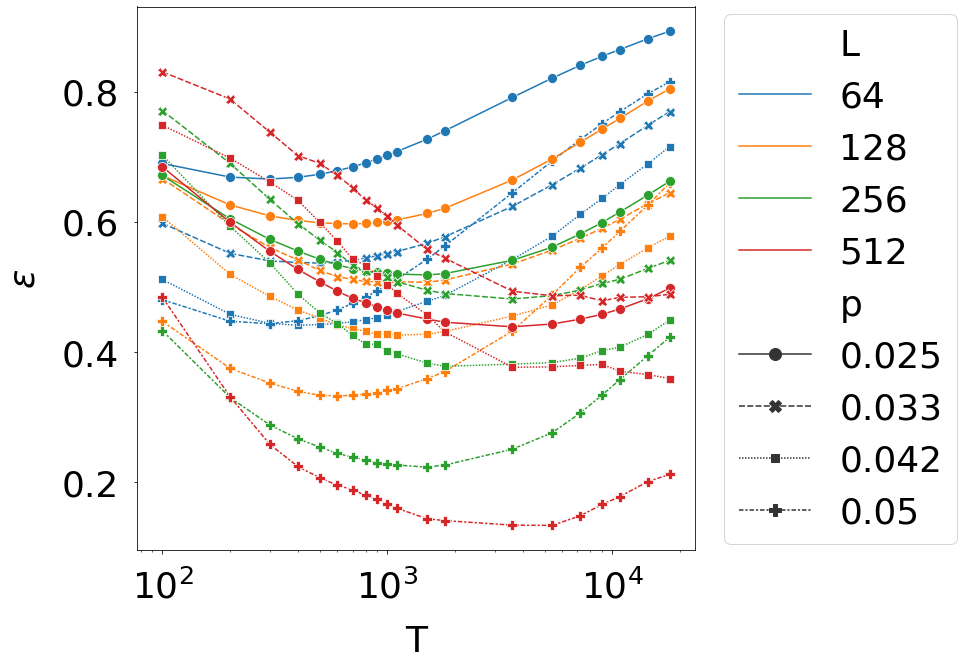

In [376]:
gamma = 3.0

auc_curve = calculate_roc_curve_gamma(gamma, PERCENTS_ETA, LS, TS, "determ", njobs=7)
plot_global_auc_curves(auc_curve, gamma)

## Find an optimal T(L)

Let's see on the optimal $T(L)$ for different $\gamma$

### Local trands

Let's try to find a better parameter using a local plot

In [377]:
def plot_auc_curve(auc_curve, ax=None):
    plt_ax = ax or plt
    used = set()

    for _, row in auc_curve.iterrows():
        L = row["L"]
        ETA = row["ETA"]
        A = row["A"]

        if L == 64:
            marker = "|"
            linestyle = "solid"
        elif L == 128:
            marker = "*"
            linestyle = "dotted"
        elif L == 256:
            marker = "x"
            linestyle = "dashed"
        else:
            marker = "1"
            linestyle = "-."

        if L in used:
            label = None
        else:
            label = f"L={L}"
            used.add(L)

        fpr, tpr, thresholds = row["results"]

        plt_ax.plot(fpr, tpr, marker=marker, linestyle=linestyle, color="black", linewidth=1, markersize=10, alpha=0.7, label=label)

    if ax is not None:
        plt_ax.set_title(r"ROC curves, $\gamma=$" + str(gamma))
        plt_ax.set_xlim(0, 1)
        plt_ax.set_ylim(0, 1)
        plt_ax.set_xlabel("False Positive Rate")
        plt_ax.set_ylabel("True Positive Rate")
        plt_ax.legend(markerscale=2)
    else:
        plt_ax.title(r"ROC curves, $\gamma=$" + str(gamma))
        plt_ax.xlim(0, 1)
        plt_ax.ylim(0, 1)
        plt_ax.xlabel("False Positive Rate")
        plt_ax.ylabel("True Positive Rate")
        plt_ax.legend(markerscale=2)

In [378]:
def plot_auc_curve(auc_curve, ax=None):
    exploded = auc_curve.explode("fpr", ignore_index=True).drop(columns=["results", "tpr"])
    exploded["tpr"] = auc_curve["tpr"].explode(ignore_index=True)
    exploded["fpr"] = exploded["fpr"].astype(float)
    exploded["tpr"] = exploded["tpr"].astype(float)
    
    sns.lineplot(data=exploded[::5], x="fpr", y="tpr", hue="L", style="p", markers=True, palette="tab10", markersize=10, legend=False, ax=ax)
    if ax is not None:
        #ax.set_title(r"ROC curves, $\gamma=$" + str(gamma))
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1], [0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1], [0, 0.2, 0.4, 0.6, 0.8, 1])
        ax.set_xlabel("False Positive Rate")
        ax.set_ylabel("True Positive Rate")
        #plt.legend(markerscale=2)
    else:
        #plt.title(r"ROC curves, $\gamma=$" + str(gamma))
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1], [0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1], [0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        #plt.legend(markerscale=2)

In [379]:
def plot_local_global(gamma, t_scaling, LS, PERCENTS_ETA, TS_local, TS_global):
    local_aucs = []

    for i, L in enumerate(LS):
        TS_local_scaled = [int(t_scaling**i * t) for t in TS_local]
        auc_curve = calculate_roc_curve_gamma(gamma, PERCENTS_ETA, [L], TS_local_scaled, "determ", njobs=7)
        local_aucs.append(auc_curve)

    local_auc_curves = pd.concat(local_aucs)

    global_auc_curve = calculate_roc_curve_gamma(gamma, PERCENTS_ETA, LS, TS_global, "determ", njobs=7)
    best_aucs = global_auc_curve.iloc[global_auc_curve.groupby(["L", "p"])["eps"].idxmin()]
    
    #fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    #fig.subplots_adjust(wspace=0.3)
    #plot_auc_curve(best_aucs, ax1)
    #plot_global_auc_curves(global_auc_curve, gamma, ax2)
    plot_auc_curve(best_aucs)
    plt.show()
    plot_global_auc_curves(global_auc_curve, gamma)
    plt.show()
    plt.show()

    ax = sns.relplot(data=local_auc_curves, x="T", y="eps", style="p", hue="L", markers=True, palette="tab10", markersize=10, col="L", 
                     kind="line", facet_kws={'sharey': True, 'sharex': False})
    plt.suptitle("T near to local minimum", y=1.1)
    ax.set_axis_labels("T", "$\epsilon$")
    ax._legend.set_bbox_to_anchor([1.02, 0.61])
    ax._legend.set_frame_on(True)
    plt.show()

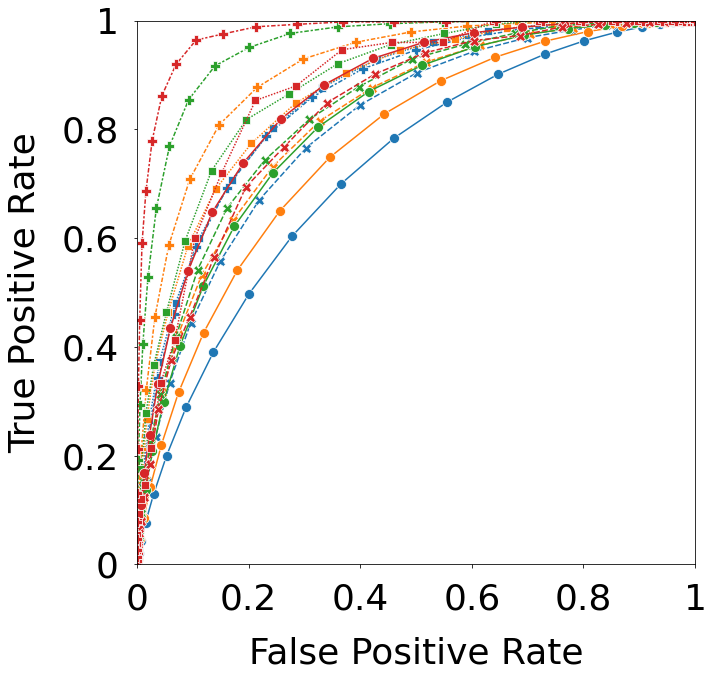

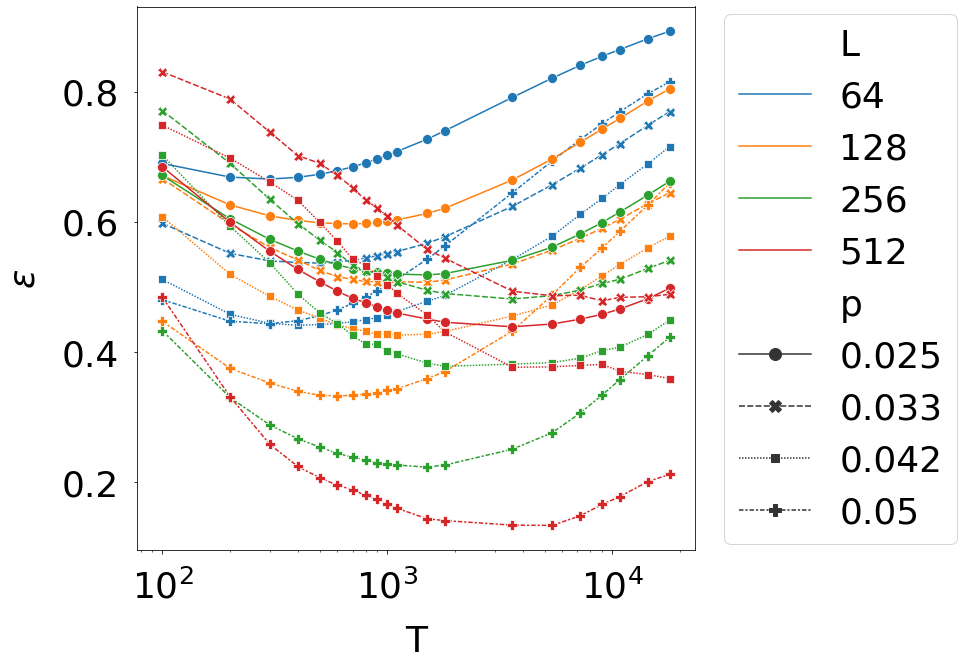

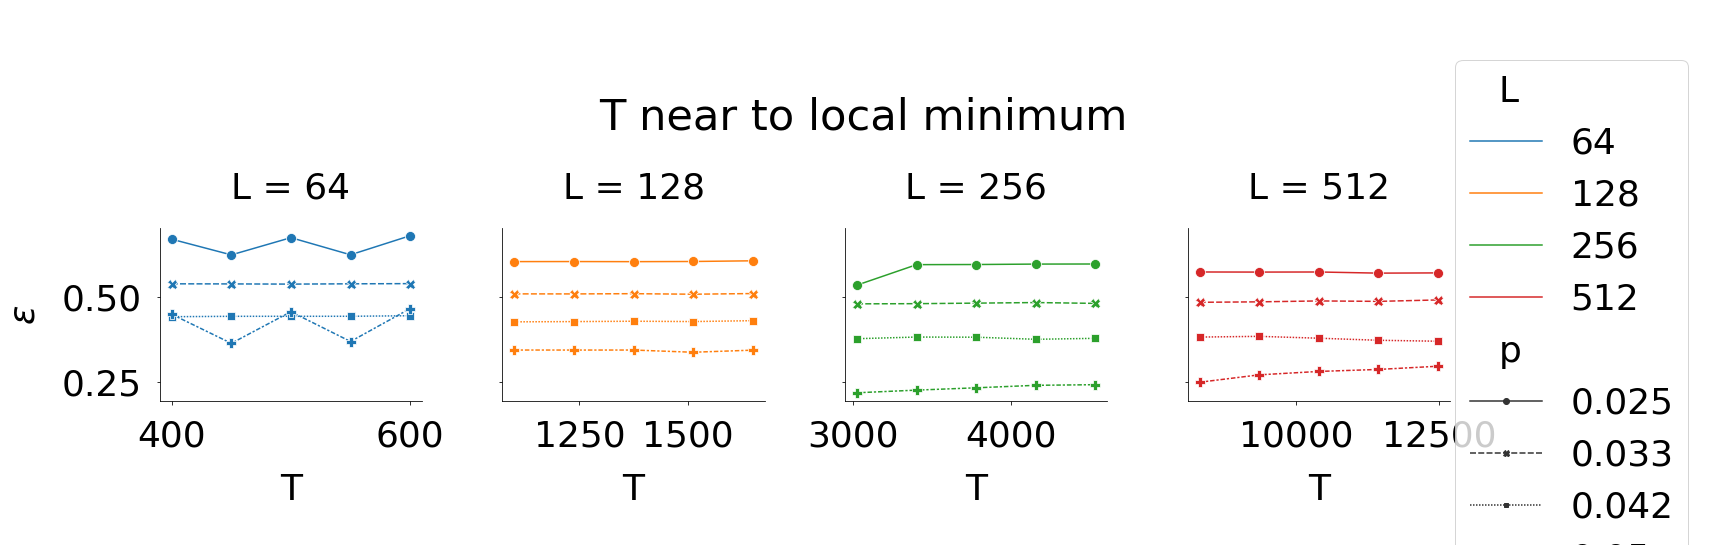

In [394]:
gamma = 3.0
t_scaling = 2.75
TS_local = [400, 450, 500, 550, 600]
TS_global = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1500, 1800, 1800*2, 1800*3, 1800*4, 1800*5, 1800*6, 1800*8, 1800*10]

plot_local_global(gamma, t_scaling, LS, PERCENTS_ETA, TS_local, TS_global)

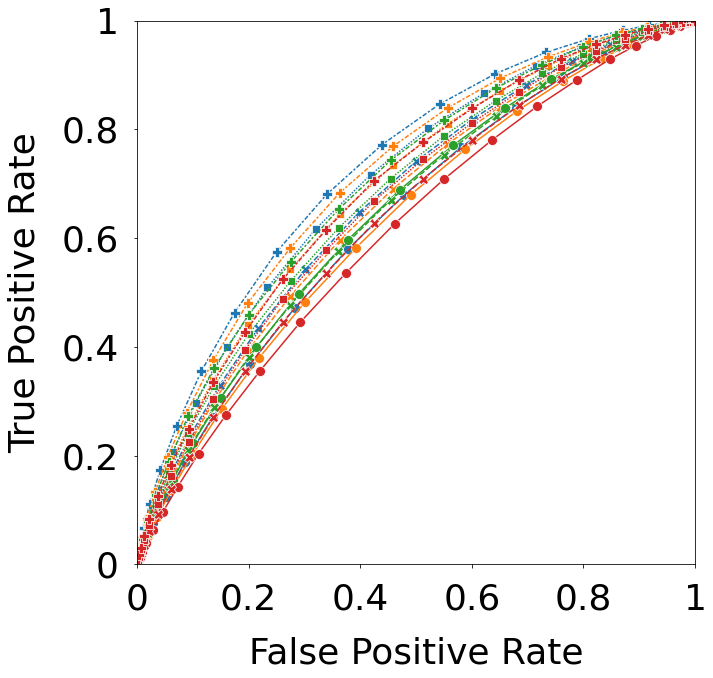

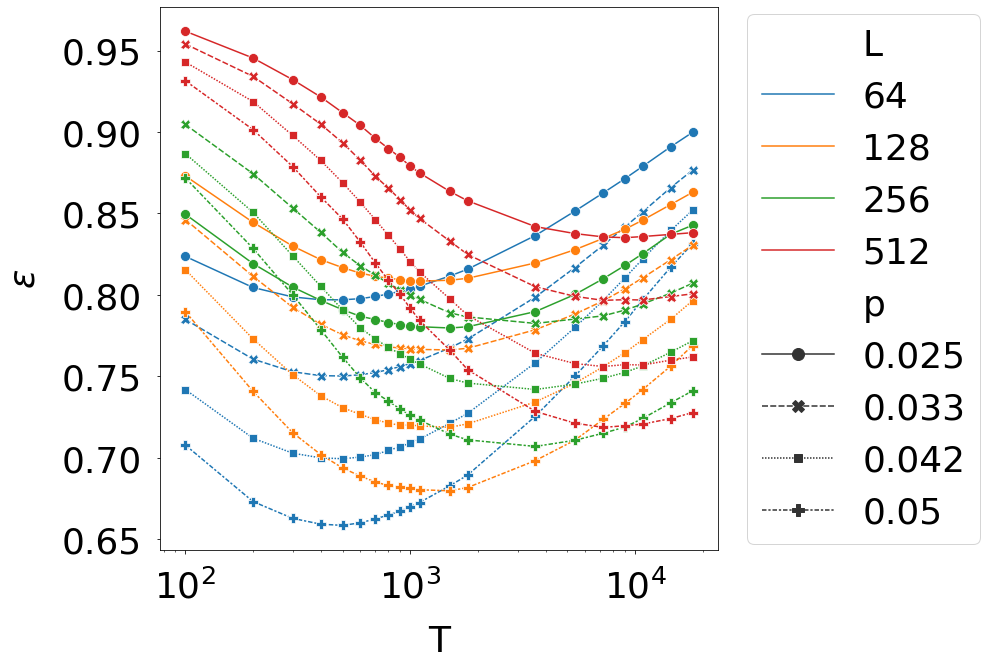

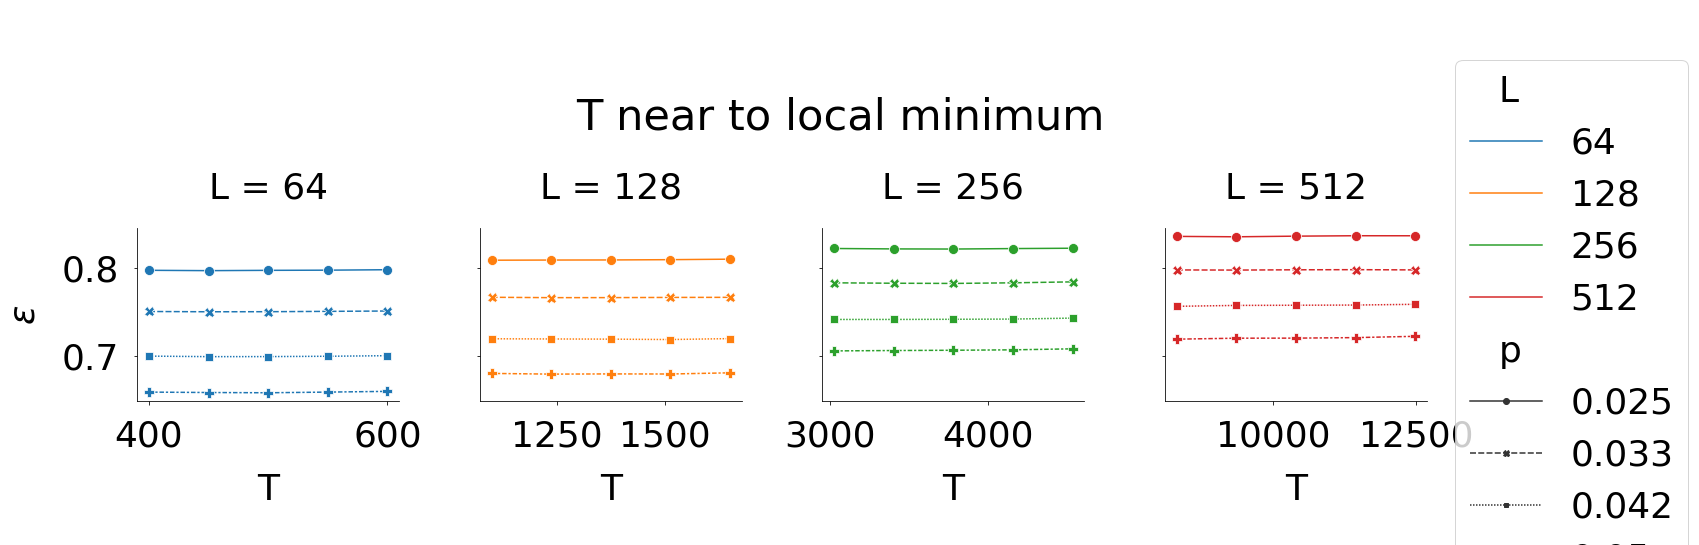

In [381]:
gamma = 2.8
plot_local_global(gamma, t_scaling, LS, PERCENTS_ETA, TS_local, TS_global)

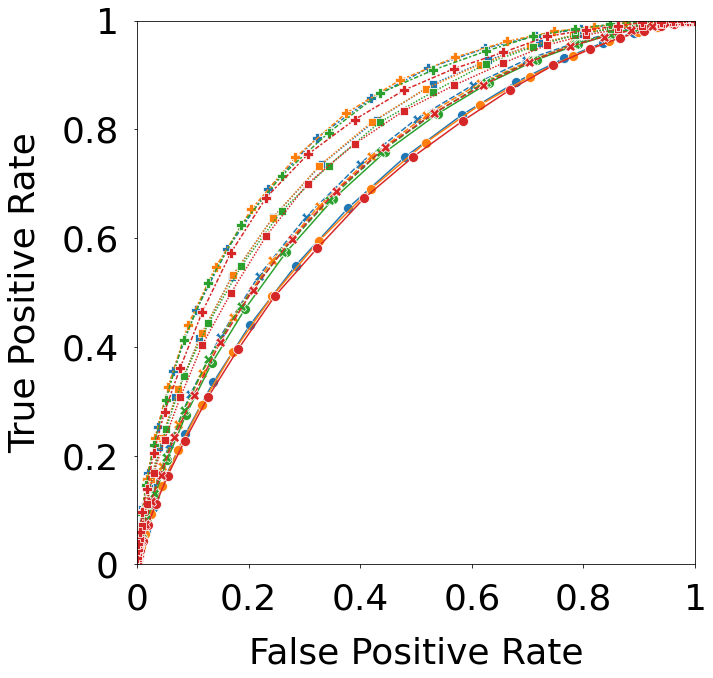

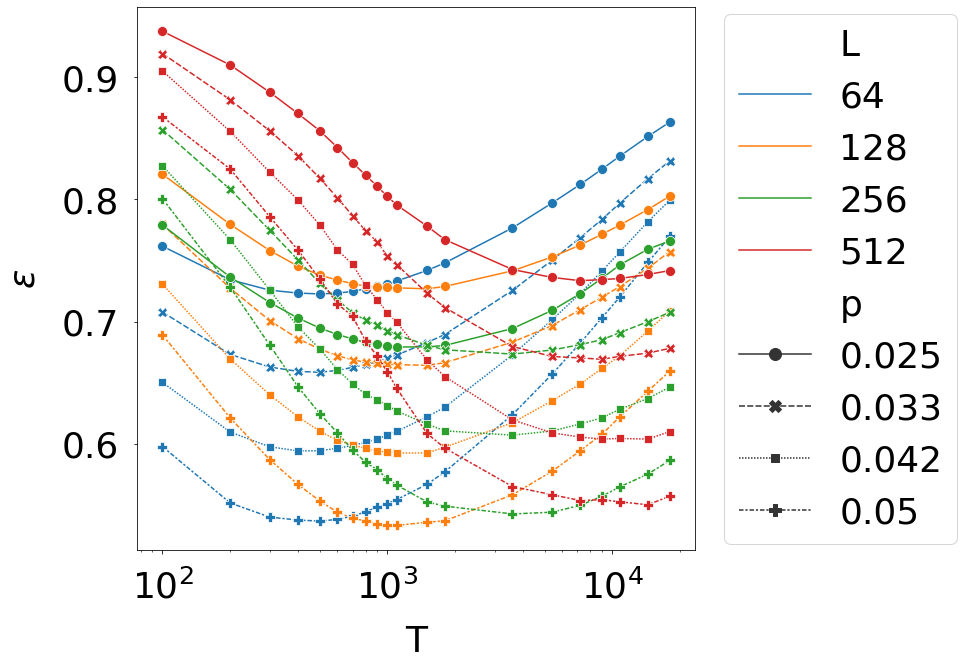

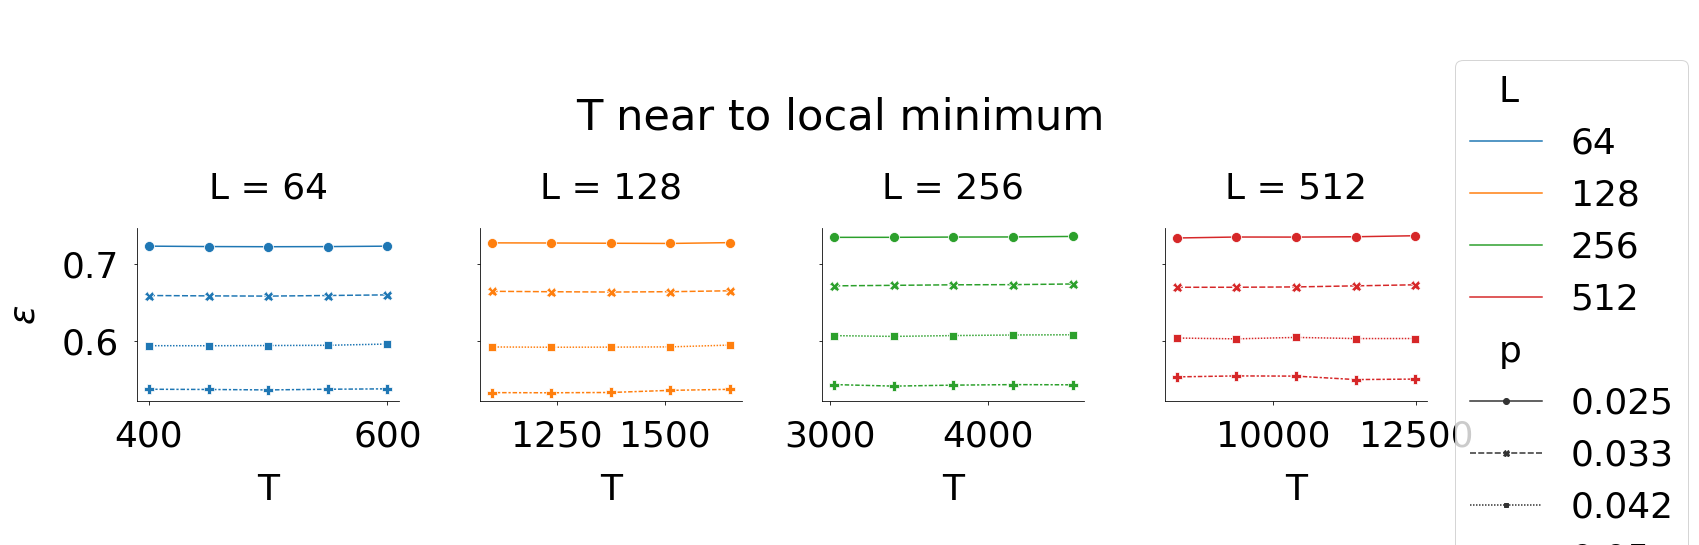

In [395]:
gamma = 2.9
plot_local_global(gamma, t_scaling, LS, PERCENTS_ETA, TS_local, TS_global)

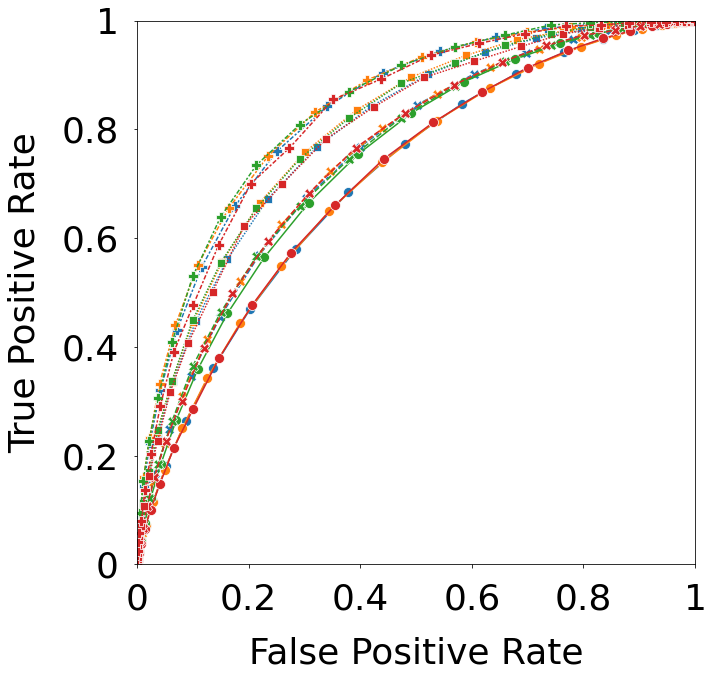

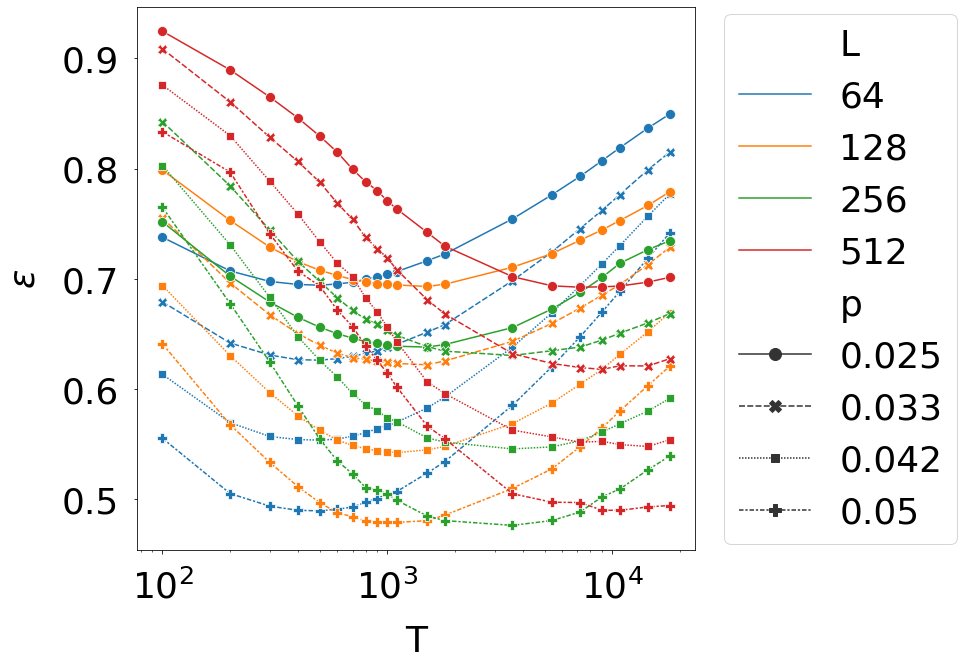

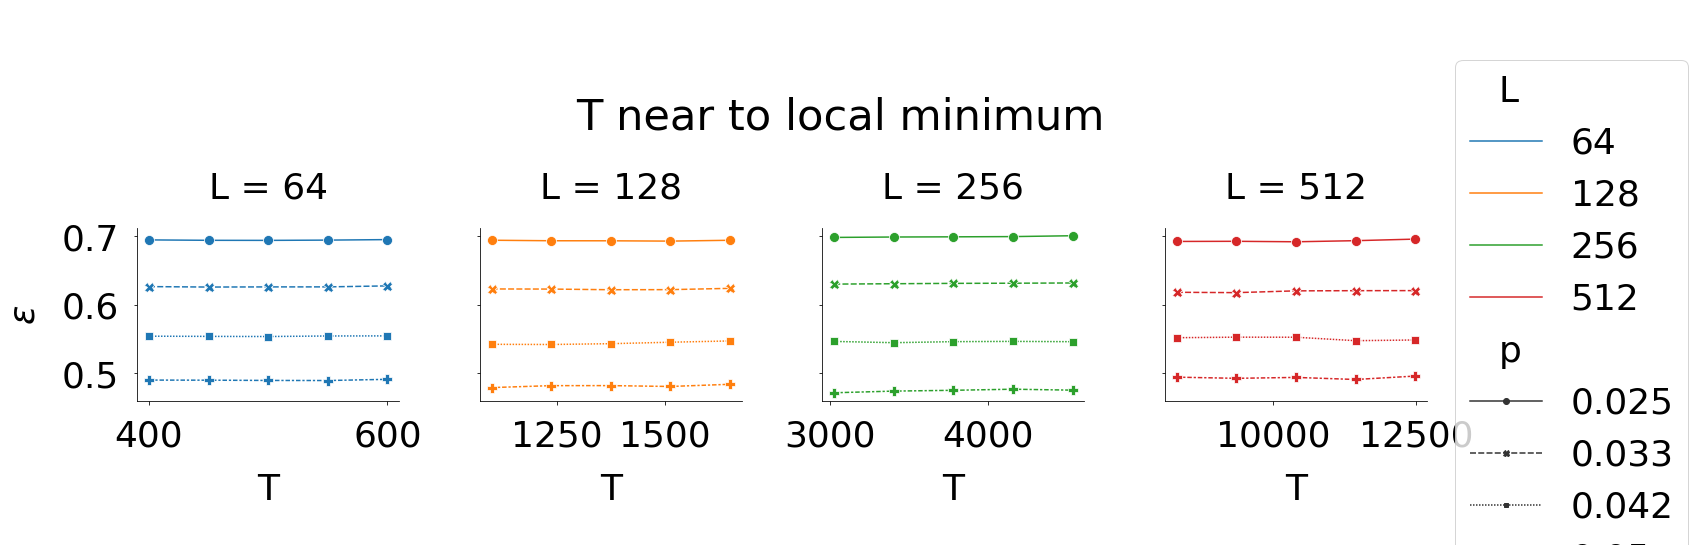

In [382]:
gamma = 2.93
plot_local_global(gamma, t_scaling, LS, PERCENTS_ETA, TS_local, TS_global)

We can see that $T(L) = 2.75^{\log_{2}\frac{L}{64}} \cdot 500$ shows good results. But the graph for large fields is fluctuated for small $p$.

### Statistics for optimal $\gamma$ and $T(L)$

Statistically prove that we have chosen the optimal parameters.

In [383]:
t_scaling = 2.75
best_t = 500

TS = [best_t, int(best_t * t_scaling), int(best_t * t_scaling**2), int(best_t*t_scaling**3)]
gammas = [2.87, 2.88, 2.89, 2.9, 2.91, 2.92, 2.93, 2.94, 2.95, 2.96]

args = []
add_t = []
add_p = []
add_gamma = []

for percent in PERCENTS_ETA:
    for gamma in gammas:
        for T, L in zip(TS, LS):
            ETA = int(L**gamma * percent)
            A = np.exp(-1. / T)
            args.append((L, ETA, A, "determ"))
            add_t.append(T)
            add_p.append(percent)
            add_gamma.append(gamma)

abel_heap.calculate_conditional_probability_parallel(args, K_BINS=200, use_cache=True, njobs=7)
auc_curve = abel_heap.calculate_roc_curve_parallel(args, K_BINS=200, use_cache=True, njobs=7)

auc_curve["p"] = add_p
auc_curve["T"] = add_t
auc_curve["gamma"] = add_gamma
auc_curve["fpr"] = auc_curve["results"].apply(lambda x: list(x[0]))
auc_curve["tpr"] = auc_curve["results"].apply(lambda x: list(x[1]))
auc_curve["eps"] = auc_curve["results"].apply(lambda x: np.min(x[0] + (1 - x[1]))) # fpr + (1 - tpr)

In [384]:
#var = auc_curve.groupby(["p", "gamma"])["eps"].var().groupby("gamma").mean().rename("var")
var = auc_curve.groupby(["p", "gamma"])["eps"].var().rename("var").reset_index()

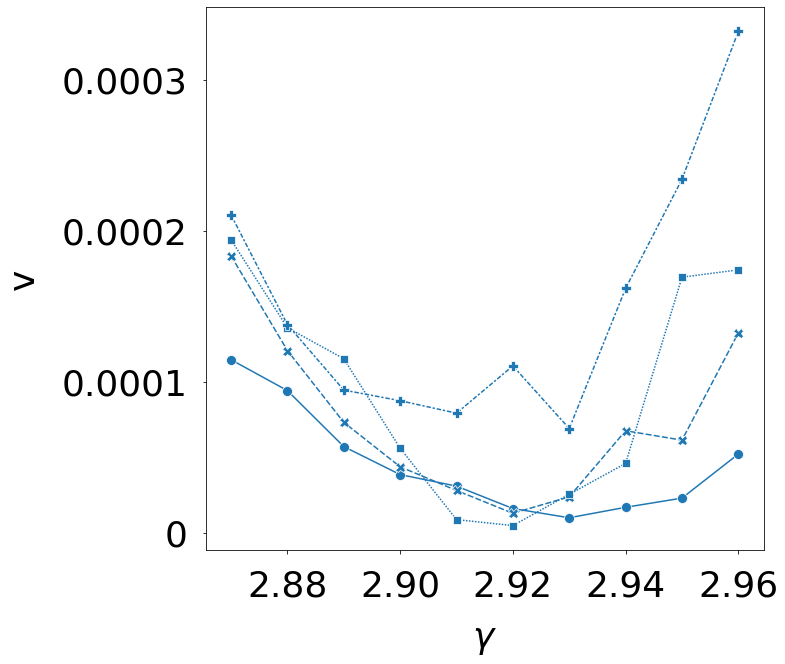

In [389]:
sns.lineplot(data=var, x="gamma", y="var", style="p", markers=True, palette="tab10", markersize=10, legend=False)
plt.ylabel("v")
#plt.xticks([2.60, 2.62, 2.64, 2.66, 2.68, 2.70], [2.60, 2.62, 2.64, 2.66, 2.68, 2.70])
plt.yticks([0, 0.0001, 0.0002, 0.0003], [0, 0.0001, 0.0002, 0.0003])
plt.xlabel("$\gamma$")
plt.show()

In [390]:
from sklearn.linear_model import LinearRegression
from collections import defaultdict

gamma2coef = defaultdict(list)
absolute_coef = defaultdict(list)

for k, v in auc_curve.groupby(["gamma", "p"]):
    linreg = LinearRegression()
    y = v["eps"]
    X = np.array(v["T"]).reshape(y.shape[0], 1)
    linreg = linreg.fit(X, y)
    
    gamma2coef[k[0]].append(linreg.coef_[0])
    
    absolute_coef["gamma"].append(k[0])
    absolute_coef["p"].append(k[1])
    absolute_coef["absolute_coef"].append(np.abs(linreg.coef_[0]))
    
absolute_coef = pd.DataFrame(data=absolute_coef)

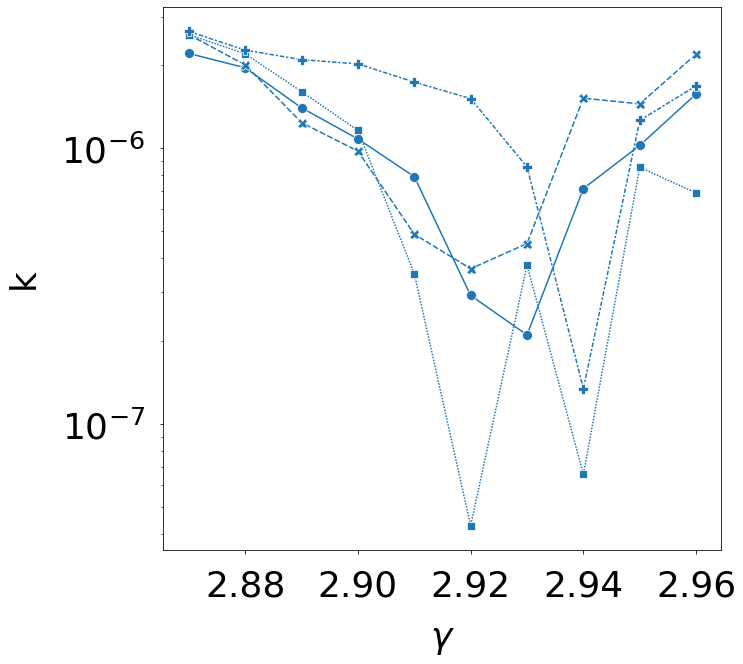

In [391]:
sns.lineplot(data=absolute_coef, x="gamma", y="absolute_coef", style="p", markers=True, palette="tab10", markersize=10, legend=False)
plt.ylabel("k")
plt.yscale("log")
plt.xlabel("$\gamma$")
plt.show()

In [357]:
from shapely.geometry import Polygon
from IPython.display import display
from copy import deepcopy

def calculate_IoU_fixed_gamma(data):
    IoU = {}
    for p, by_p in data.groupby(["p"]):
        unions, intersects = None, None
        for L, by_p_l in by_p.groupby(["L"]):
            fpr = by_p_l["fpr"].iloc[0]
            tpr = by_p_l["tpr"].iloc[0]
            polygon = Polygon([(x, y) for x, y in zip(fpr, tpr)] + [(1, 0)])
            if unions is None:
                unions = deepcopy(polygon)
                intersects = deepcopy(polygon)
            else:
                intersects = intersects.intersection(polygon)
                unions = unions.union(polygon)
        
        IoU[p] = intersects.area / unions.area
        
    return IoU

def calculate_IoU(data):
    results = defaultdict(list)
    for gamma, by_gamma in data.groupby(["gamma"]):
        IoU_gamma = calculate_IoU_fixed_gamma(by_gamma)
        results["p"] += IoU_gamma.keys()
        results["IoU"] += IoU_gamma.values()
        results["gamma"] += [gamma] * len(IoU_gamma)
    return pd.DataFrame(data=results)

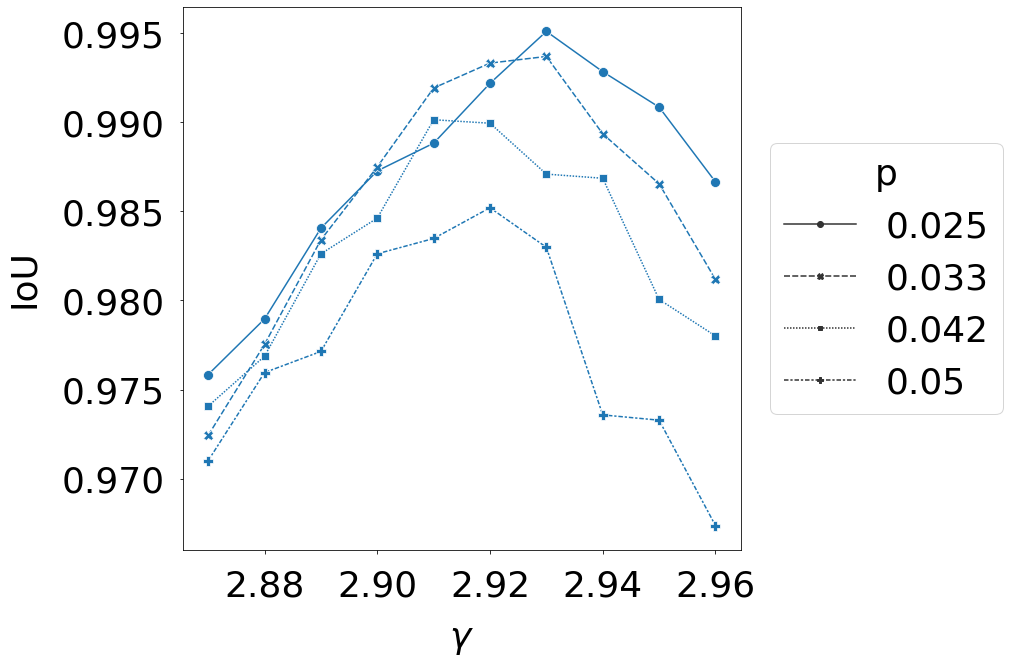

In [392]:
IoU = calculate_IoU(auc_curve)
sns.lineplot(data=IoU, x="gamma", y="IoU", style="p", markers=True, palette="tab10", markersize=10)
#plt.yscale("log")
plt.legend(bbox_to_anchor=[1.02, 0.5], loc='center left', title="p")
plt.xlabel("$\gamma$")
plt.show()

In [359]:
def calculate_event_rate(gamma, PERCENTS_ETA, LS, model):    
    event_rates = {
        "event_rate": [],
        "L": [],
        "p": [],
        "model": []
    }
    
    for L in LS:
        ETAs = []
        for percent in PERCENTS_ETA:
            ETAs.append(int(L**gamma * percent))
        count_events = abel_heap.calculate_events(L, ETAs, model)
        total_events = count_events[-1]
        count_events = count_events[:-1]
        
        count_events = list(map(lambda x: x / total_events, count_events))
        event_rates["event_rate"].extend(count_events)
        event_rates["L"].extend([L] * len(PERCENTS_ETA))
        event_rates["model"].extend([model] * len(PERCENTS_ETA))
        event_rates["p"].extend(PERCENTS_ETA)
    
    return pd.DataFrame(event_rates)

In [360]:
def calculate_roc_curve_gamma_min_event_rate(gamma, PERCENTS_ETA, LS, TS, model, njobs=-1, min_event_rate=1e-9):
    # build args
    get_eta = lambda L, percent: int(L**gamma * percent)
    get_a = lambda T: np.exp(-1. / T)
    
    args = []
    add_t = []
    add_p = []
    add_gamma = []
    
    event_rate = calculate_event_rate(gamma, PERCENTS_ETA, LS, "determ")

    for L in LS:
        for T in TS:
            A = get_a(T)
            for percent in PERCENTS_ETA:
                ETA = get_eta(L, percent)
                
                if (event_rate[(event_rate["p"] == percent) & (event_rate["L"] == L)]["event_rate"] > min_event_rate).all():
                    add_t.append(T)
                    add_p.append(percent)
                    add_gamma.append(gamma)
                    args.append((L, ETA, A, model))
                    
    # run subprograms
    abel_heap.calculate_conditional_probability_parallel(args, K_BINS=200, use_cache=True, njobs=njobs)
    auc_curve = abel_heap.calculate_roc_curve_parallel(args, K_BINS=200, use_cache=True, njobs=njobs)

    # calculate some useful columns
    auc_curve["eps"] = auc_curve["results"].apply(lambda x: np.NaN if len(x[0]) == 0 else np.min(x[0] + (1 - x[1]))) # fpr + (1 - tpr)
    auc_curve["fpr"] = auc_curve["results"].apply(lambda x: list(x[0]))
    auc_curve["tpr"] = auc_curve["results"].apply(lambda x: list(x[1]))
    auc_curve["T"] = add_t
    auc_curve["p"] = add_p
    auc_curve["gamma"] = add_gamma
    
    return auc_curve

In [268]:
gamma = 2.93
PERCENTS_ETA_EXTENDED = [0.01 / 6, 0.05 / 6, 0.1 / 6, 0.15 / 6, 0.2 / 6, 0.25 / 6, 0.3 / 6, 0.35 / 6, 0.4 / 6, 0.45 / 6, 0.5 / 6]

roc_curve = calculate_roc_curve_gamma_min_event_rate(gamma, PERCENTS_ETA_EXTENDED, LS, TS, "determ", njobs=7, min_event_rate=1e-7)
opt_metric = pd.DataFrame(roc_curve.groupby(["L", "model", "p"])["eps"].min()).reset_index()
opt_metric["p"] = opt_metric["p"].astype(float)
event_rate = calculate_event_rate(gamma, PERCENTS_ETA_EXTENDED, LS, "determ")
opt_metric = pd.merge(opt_metric, event_rate, on=["L", "p", "model"], how="left")

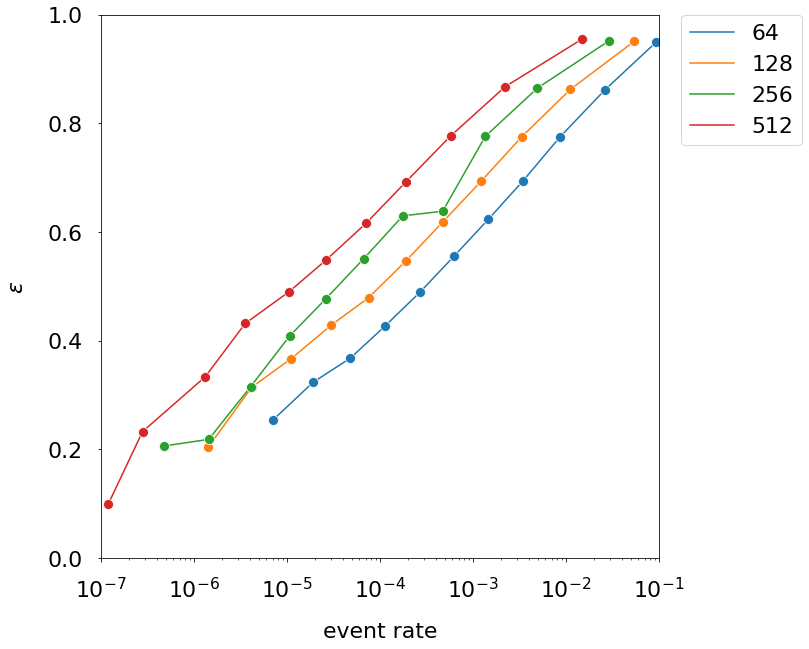

In [269]:
sns.lineplot(data=opt_metric, x="event_rate", y="eps", hue="L", marker="o", palette="tab10", markersize=10)

# plt.title(f"Quality of predictions depending on event rate in BTW model")
plt.xlabel("event rate")
plt.ylabel("$\epsilon$")
plt.xscale("log")
plt.ylim([0, 1])
plt.xlim([1e-7, 1e-1])
#plt.ylim([0.3, 1])
#plt.xlim([1e-6, 1e-1])
plt.legend(bbox_to_anchor=(1.02,1.02), loc="upper left", markerscale=2)
plt.show()

In [296]:
gamma = 3
PERCENTS_ETA_EXTENDED = [0.01 / 6, 0.05 / 6, 0.1 / 6, 0.15 / 6, 0.2 / 6, 0.25 / 6, 0.3 / 6, 0.35 / 6, 0.4 / 6, 0.45 / 6, 0.5 / 6]

roc_curve = calculate_roc_curve_gamma_min_event_rate(gamma, PERCENTS_ETA_EXTENDED, LS, TS, "determ", njobs=7, min_event_rate=1e-7)
opt_metric = pd.DataFrame(roc_curve.groupby(["L", "model", "p"])["eps"].min()).reset_index()
opt_metric["p"] = opt_metric["p"].astype(float)
event_rate = calculate_event_rate(gamma, PERCENTS_ETA_EXTENDED, LS, "determ")
opt_metric = pd.merge(opt_metric, event_rate, on=["L", "p", "model"], how="left")

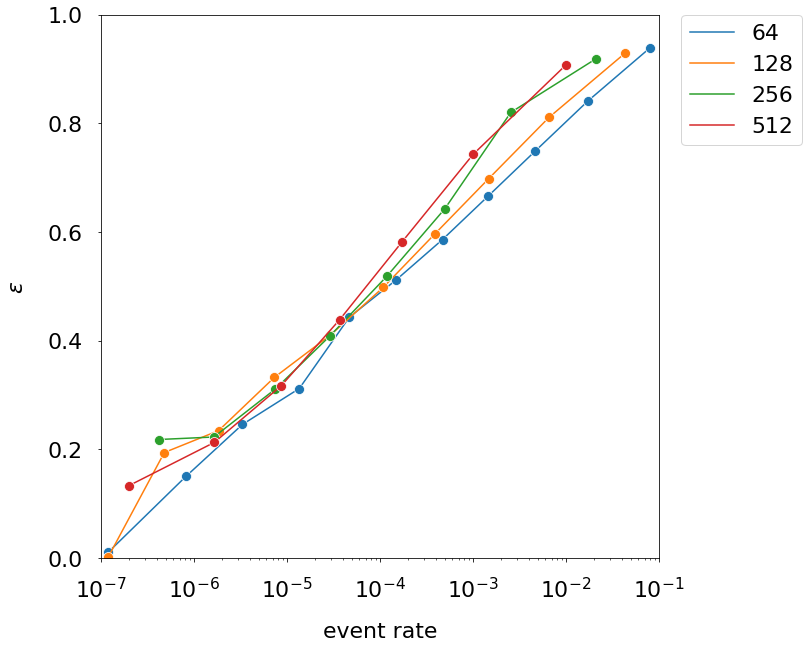

In [297]:
sns.lineplot(data=opt_metric, x="event_rate", y="eps", hue="L", marker="o", palette="tab10", markersize=10)

# plt.title(f"Quality of predictions depending on event rate in BTW model")
plt.xlabel("event rate")
plt.ylabel("$\epsilon$")
plt.xscale("log")
plt.ylim([0, 1])
plt.xlim([1e-7, 1e-1])
#plt.ylim([0.3, 1])
#plt.xlim([1e-6, 1e-1])
plt.legend(bbox_to_anchor=(1.02,1.02), loc="upper left", markerscale=2)
plt.show()

In [304]:
gamma = 2.99
PERCENTS_ETA_EXTENDED = [0.01 / 6, 0.05 / 6, 0.1 / 6, 0.15 / 6, 0.2 / 6, 0.25 / 6, 0.3 / 6, 0.35 / 6, 0.4 / 6, 0.45 / 6, 0.5 / 6]

roc_curve = calculate_roc_curve_gamma_min_event_rate(gamma, PERCENTS_ETA_EXTENDED, LS, TS, "determ", njobs=7, min_event_rate=1e-7)
opt_metric = pd.DataFrame(roc_curve.groupby(["L", "model", "p"])["eps"].min()).reset_index()
opt_metric["p"] = opt_metric["p"].astype(float)
event_rate = calculate_event_rate(gamma, PERCENTS_ETA_EXTENDED, LS, "determ")
opt_metric = pd.merge(opt_metric, event_rate, on=["L", "p", "model"], how="left")

In [305]:
opt_metric

,L,model,p,eps,event_rate
0,64,determ,0.001667,0.94165,8.217006e-02
1,64,determ,0.008333,0.83553,1.836166e-02
2,64,determ,0.016667,0.72922,5.115400e-03
3,64,determ,0.025000,0.63338,1.666460e-03
4,64,determ,0.033333,0.54754,5.642400e-04
5,64,determ,0.041667,0.46242,1.901200e-04
6,64,determ,0.050000,0.38749,6.236000e-05
7,64,determ,0.058333,0.32714,1.938000e-05
8,64,determ,0.066667,0.24858,5.380000e-06
9,64,determ,0.075000,0.15224,1.360000e-06


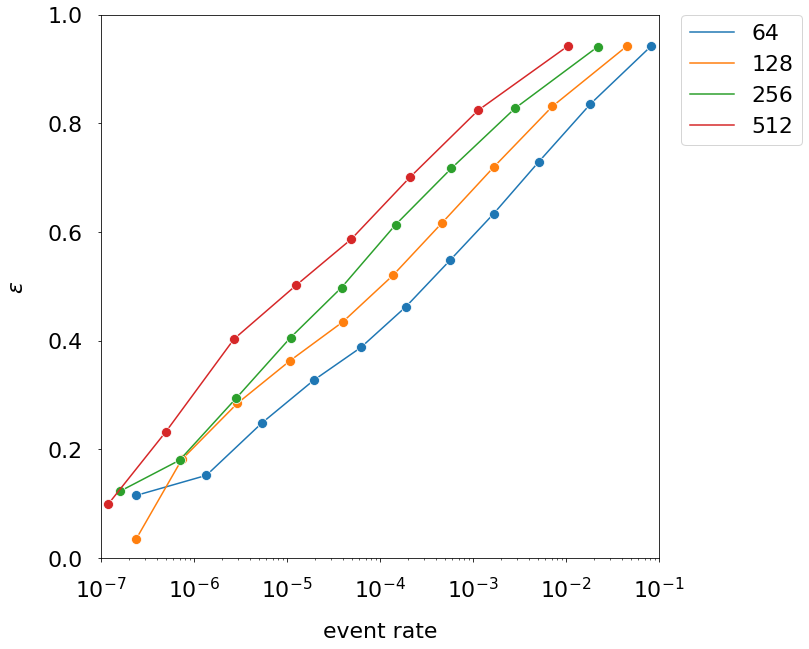

In [306]:
#sns.scatterplot(data=opt_metric, x="event_rate", y="eps", hue="L", style="p", size="gamma", markers=True, palette="tab10", s=300)
#sns.scatterplot(data=opt_metric, x="event_rate", y="eps", hue="L", markers=True, palette="tab10", s=300)
sns.lineplot(data=opt_metric, x="event_rate", y="eps", hue="L", marker="o", palette="tab10", markersize=10)

# plt.title(f"Quality of predictions depending on event rate in BTW model")
plt.xlabel("event rate")
plt.ylabel("$\epsilon$")
plt.xscale("log")
plt.ylim([0, 1])
plt.xlim([1e-7, 1e-1])
#plt.ylim([0.3, 1])
#plt.xlim([1e-6, 1e-1])
plt.legend(bbox_to_anchor=(1.02,1.02), loc="upper left", markerscale=2)
plt.show()

In [361]:
gamma = 3.01
PERCENTS_ETA_EXTENDED = [0.01 / 6, 0.05 / 6, 0.1 / 6, 0.15 / 6, 0.2 / 6, 0.25 / 6, 0.3 / 6, 0.35 / 6, 0.4 / 6, 0.45 / 6, 0.5 / 6]

roc_curve = calculate_roc_curve_gamma_min_event_rate(gamma, PERCENTS_ETA_EXTENDED, LS, TS, "determ", njobs=7, min_event_rate=1e-7)
opt_metric = pd.DataFrame(roc_curve.groupby(["L", "model", "p"])["eps"].min()).reset_index()
opt_metric["p"] = opt_metric["p"].astype(float)
event_rate = calculate_event_rate(gamma, PERCENTS_ETA_EXTENDED, LS, "determ")
opt_metric = pd.merge(opt_metric, event_rate, on=["L", "p", "model"], how="left")

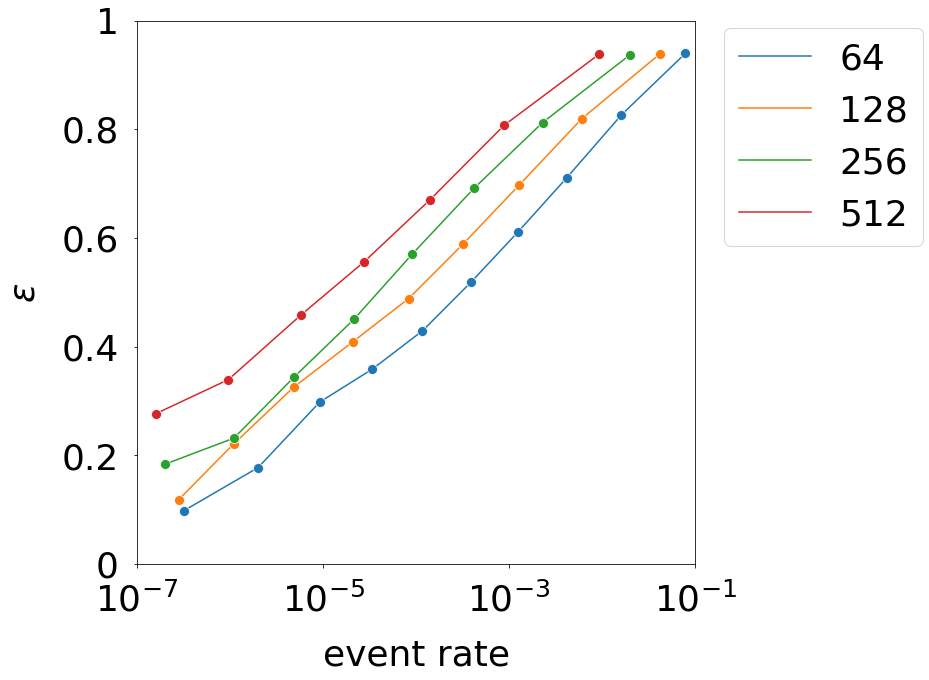

In [393]:
#sns.scatterplot(data=opt_metric, x="event_rate", y="eps", hue="L", style="p", size="gamma", markers=True, palette="tab10", s=300)
#sns.scatterplot(data=opt_metric, x="event_rate", y="eps", hue="L", markers=True, palette="tab10", s=300)
sns.lineplot(data=opt_metric, x="event_rate", y="eps", hue="L", marker="o", palette="tab10", markersize=10)

# plt.title(f"Quality of predictions depending on event rate in BTW model")
plt.xlabel("event rate")
plt.ylabel("$\epsilon$")
plt.xscale("log")
plt.ylim([0, 1])
plt.xlim([1e-7, 1e-1])
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1], [0, 0.2, 0.4, 0.6, 0.8, 1])
#plt.ylim([0.3, 1])
#plt.xlim([1e-6, 1e-1])
plt.legend(bbox_to_anchor=(1.02,1.02), loc="upper left", markerscale=2)
plt.show()